## Introduction

I thought I'd use this application as an opportunity to work on a fresh project. I chose a simple dataset to put my skills in R, tidy functions and regression analysis on display. I wrote this project on a *Jupyter Notebook*.

### The Dataset
For this project, I'm using the [University of California, Berkeley Admissions dataset](https://stat.ethz.ch/R-manual/R-patched/library/datasets/html/UCBAdmissions.html) available as a function in the [datasets](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/00Index.html) package.

The dataset contains admissions information from Berekely's six largest departments in 1973. 

### The Objective
This dataset is freqeuntly used to illustrate [*Simpson's Paradox*](https://en.wikipedia.org/wiki/Simpson%27s_paradox). I will attempt to do the same.


In [1]:
# loading all necessary libraries
library_list <- c('broom', 'dplyr', 'ggplot2', 'scales', 'forcats')

lapply(library_list, library, character.only = TRUE)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


[[1]]
[1] "broom"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "dplyr"     "broom"     "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[3]]
 [1] "ggplot2"   "dplyr"     "broom"     "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "scales"    "ggplot2"   "dplyr"     "broom"     "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "forcats"   "scales"    "ggplot2"   "dplyr"     "broom"     "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"

In [2]:
# load and view the data
data("UCBAdmissions")
print(UCBAdmissions)

, , Dept = A

          Gender
Admit      Male Female
  Admitted  512     89
  Rejected  313     19

, , Dept = B

          Gender
Admit      Male Female
  Admitted  353     17
  Rejected  207      8

, , Dept = C

          Gender
Admit      Male Female
  Admitted  120    202
  Rejected  205    391

, , Dept = D

          Gender
Admit      Male Female
  Admitted  138    131
  Rejected  279    244

, , Dept = E

          Gender
Admit      Male Female
  Admitted   53     94
  Rejected  138    299

, , Dept = F

          Gender
Admit      Male Female
  Admitted   22     24
  Rejected  351    317



### Tidy up the data
As can be seen, the dataset is currently in an unyieldy format: It's a three dimensional array, tablulating 4526 observations across 3 the three following variables:

1. 	Admit 	Admitted, Rejected
2. 	Gender 	Male, Female
3.	Dept 	A, B, C, D, E, F 

To make further analysis possible, I'm going to convert the data into `tidy` format using the `tidy()` function from the `broom` package.

In [3]:
data_tidy <- tidy(UCBAdmissions)

print(data_tidy)

# A tibble: 24 x 4
   Admit    Gender Dept      n
   <chr>    <chr>  <chr> <dbl>
 1 Admitted Male   A       512
 2 Rejected Male   A       313
 3 Admitted Female A        89
 4 Rejected Female A        19
 5 Admitted Male   B       353
 6 Rejected Male   B       207
 7 Admitted Female B        17
 8 Rejected Female B         8
 9 Admitted Male   C       120
10 Rejected Male   C       205
# ... with 14 more rows


### Exploring the dataset
I want to explore *Simpson's Paradox*, so it's a good idea to take a look at the distribution of admits/rejections across the two available genders.

Here I use *verbs* from the `dplyr` package to group, summarize, mutate and filter my dataset.

In [4]:
data_tidy %>%
    group_by(Gender) %>%
    summarize(n = sum(n))

Gender,n
Female,1835
Male,2691


In [5]:
data_tidy_agg <- data_tidy %>%
                    group_by(Admit, Gender) %>%
                    summarize(n = sum(n)) %>%
                    ungroup() %>%
                    group_by(Gender) %>%
                    mutate(prop = n/sum(n)) %>%
                    filter(Admit == "Admitted")

print(data_tidy_agg)

# A tibble: 2 x 4
# Groups:   Gender [2]
  Admit    Gender     n  prop
  <chr>    <chr>  <dbl> <dbl>
1 Admitted Female   557 0.304
2 Admitted Male    1198 0.445


I can see the discrepancy in the acceptance rates already. 44.5% of all men (2691) who applied got admits, while only 30.4% of women applicants were admitted. Prima facie, this glaring chasm could mean that UC Berkeley discriminates its applicants based on gender.

It's worthwhile to examine this further. To get a more visual sense, I will use the `ggplot2` package to make a bar chart.

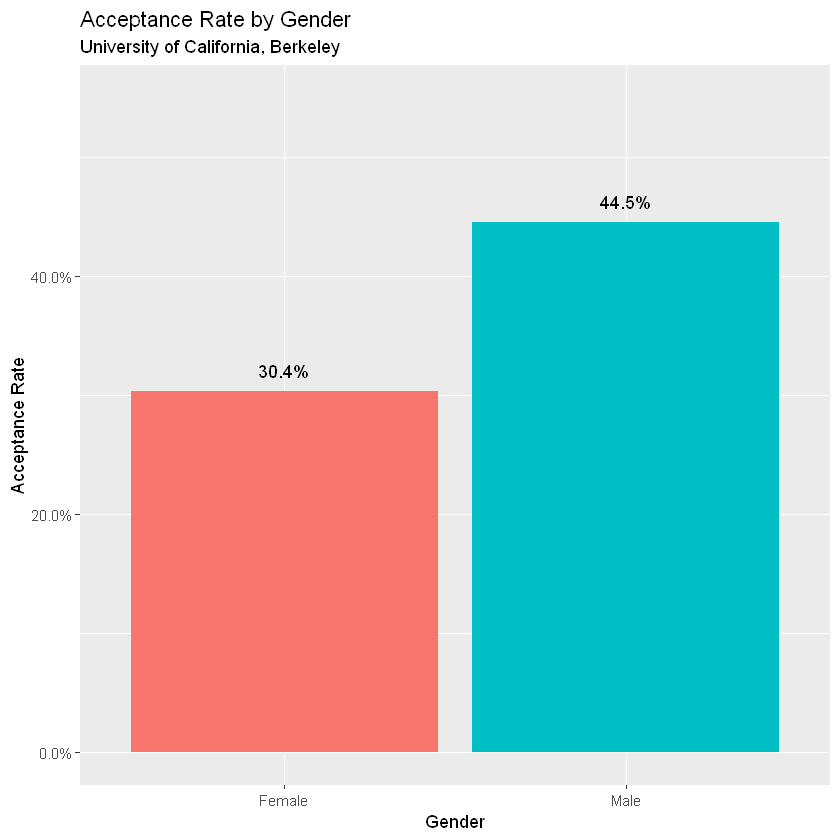

In [6]:
gender_bar_plot <- data_tidy_agg %>%
                        ggplot(aes(x = Gender, y = prop, fill = Gender)) +
                        geom_col() +
                        labs(title = "Acceptance Rate by Gender",
                                  subtitle = "University of California, Berkeley",
                                  y = "Acceptance Rate") +
                        geom_text(aes(label = percent(prop)), vjust = -1) +
                        scale_y_continuous(labels = percent, limits = c(0, 0.55)) +
                        guides(fill = FALSE)

print(gender_bar_plot)

While the above method gives us information in the aggregate, I'd like to break it down by department. I'm looking to see if all or most departments conform with this trend of preferring male applicants. I'll continue using the `dplyr` package for this and finally plot my observations in a series of bar charts.

In [7]:
data_tidy_dept <- data_tidy %>%
                    group_by(Gender, Dept) %>%
                    mutate(prop = n/sum(n)) %>%
                    filter(Admit == "Admitted")

print(data_tidy_dept)

# A tibble: 12 x 5
# Groups:   Gender, Dept [12]
   Admit    Gender Dept      n   prop
   <chr>    <chr>  <chr> <dbl>  <dbl>
 1 Admitted Male   A       512 0.621 
 2 Admitted Female A        89 0.824 
 3 Admitted Male   B       353 0.630 
 4 Admitted Female B        17 0.68  
 5 Admitted Male   C       120 0.369 
 6 Admitted Female C       202 0.341 
 7 Admitted Male   D       138 0.331 
 8 Admitted Female D       131 0.349 
 9 Admitted Male   E        53 0.277 
10 Admitted Female E        94 0.239 
11 Admitted Male   F        22 0.0590
12 Admitted Female F        24 0.0704


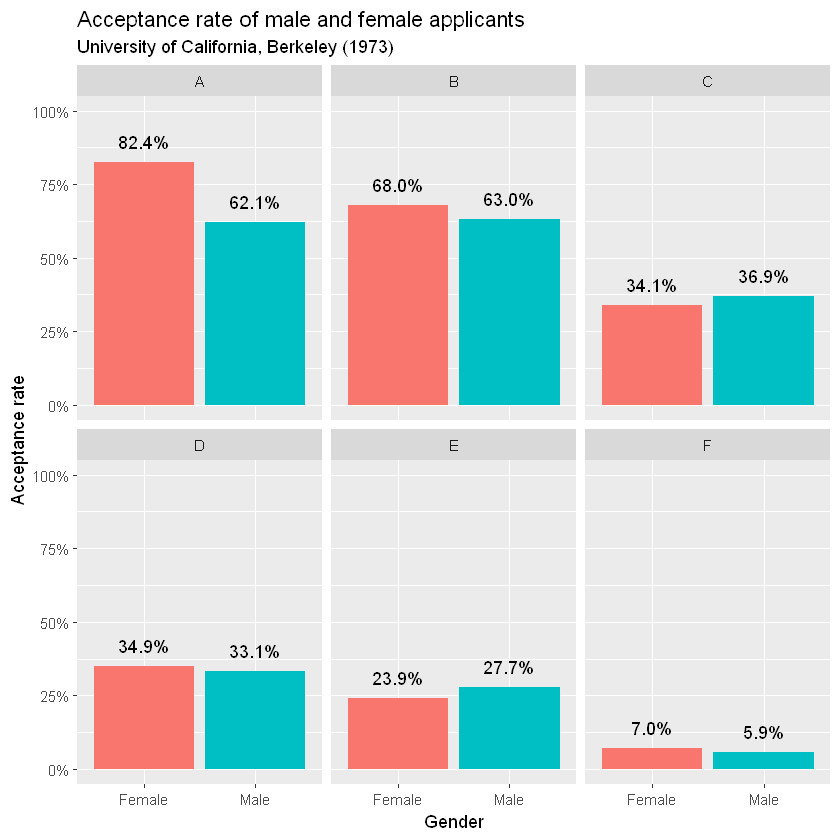

In [8]:
gender_dept_bar <- data_tidy_dept %>% 
  ggplot(aes(Gender, prop, fill = Gender)) +
  geom_col() +
  geom_text(aes(label = percent(prop)), vjust = -1) +
  labs(title = "Acceptance rate of male and female applicants",
       subtitle = "University of California, Berkeley (1973)",
       y = "Acceptance rate") +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  facet_wrap(~ Dept) +
  guides(fill = FALSE)

print(gender_dept_bar)

Breaking down the data by department makes it apparent that while Departments C and E do seem to prefer male applicants, this trend is missing from the other departments. On the other hand, Departments A and B overwhelmingly favoured women. On the surface, at least, gender based discrimination doesn't seem to be a systemic issue at Berkeley.

Taking a deeper dive into department level statistics, I can see that the distribution of applicants is not similar across departments. For example, Department B only had 25 women and 560 male applicants, while Department F had more or less similar figures for female and male applicants (341 vs 373).

In [9]:
data_tidy %>% 
    group_by(Dept, Gender) %>% 
    summarize(n = sum(n))

Dept,Gender,n
A,Female,108
A,Male,825
B,Female,25
B,Male,560
C,Female,593
C,Male,325
D,Female,375
D,Male,417
E,Female,393
E,Male,191


**What's going on here?**

At this stage, I think it is fair to hypothesize that - since there is no systemic discrimination - the discrepancy in acceptance rate by gender should disapper if we control for department.

I will use *binary logistic regression* to test my hypothesis using the `glm()` method. However, to do this, I will have to process my data a little more. I need a single row per applicant. This means my dataset will have 4526 rows. 

I don't see any way I can de-aggregate in this manner with available methods, so I will write a function that does this for me. I also have in the back of mind that I will need a `data.frame` for the `glm()` function, so I have to move out of the `tibble` that I currently have.

In [10]:
create_rows <- function(col, n) {
    rep(col, n)
}

The function is simple. It operates on one column at a time. It uses the column `n` to detemine how many rows to create. I will operate on one column at a time and append all of them to a `data.frame`.

In [11]:
data_frame <- data.frame(Admit = create_rows(data_tidy$Admit, data_tidy$n),
                        Dept = create_rows(data_tidy$Dept, data_tidy$n),
                        Gender = create_rows(data_tidy$Gender, data_tidy$n))

I'll take print out the number of rows to confirm that I have what I expect.

In [12]:
print("The number of observations:") 
print(nrow(data_frame))

head(data_frame)

[1] "The number of observations:"
[1] 4526


Admit,Dept,Gender
Admitted,A,Male
Admitted,A,Male
Admitted,A,Male
Admitted,A,Male
Admitted,A,Male
Admitted,A,Male


Before I get started with modelling, I know that `glm()` expects 0 to be a 'failure' and 1 to be a 'success'. I also know that the `Admit` column is of the data type `factor`. Therefore, I will need to reverse the levels assigned to `Admitted` and `Rejected`. As things stand now, `Admitted` will be marked 0 and `Rejected` 1.

I will use the `fct_relevel` function from the `forcats` package to achieve this.

In [13]:
data_frame$Admit <- fct_relevel(data_frame$Admit, "Rejected", "Admitted")

Time to run my model.

In [14]:
model_1 <- glm(Admit ~ Gender + Dept, data = data_frame, family = "binomial")

summary(model_1)


Call:
glm(formula = Admit ~ Gender + Dept, family = "binomial", data = data_frame)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4773  -0.9306  -0.3741   0.9588   2.3613  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.68192    0.09911   6.880 5.97e-12 ***
GenderMale  -0.09987    0.08085  -1.235    0.217    
DeptB       -0.04340    0.10984  -0.395    0.693    
DeptC       -1.26260    0.10663 -11.841  < 2e-16 ***
DeptD       -1.29461    0.10582 -12.234  < 2e-16 ***
DeptE       -1.73931    0.12611 -13.792  < 2e-16 ***
DeptF       -3.30648    0.16998 -19.452  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6044.3  on 4525  degrees of freedom
Residual deviance: 5187.5  on 4519  degrees of freedom
AIC: 5201.5

Number of Fisher Scoring iterations: 5


From the above, upon controlling for department, I can see that the coefficient for Male is `-0.09987`. It's negative! That means the model suggests that the admissions process is biased against male applicants. However, this estimate is not statistically significant.

I think we can reject our hypothesis that there was systemic gender-based discrimination in Berkely in 1973.

### Simpson's Paradox
> Simpson’s Paradox is a statistical phenomenon where an association between two variables in a population emerges, disappears or reverses when the population is divided into subpopulations.
>                                                                        
> [*Stanford Encyclopedia of Philosophy*](https://plato.stanford.edu/entries/paradox-simpson/)

Now, to take a look at the phenomenon in play, I will train three models:
1. On Gender filtered for applicants to Department A
2. On Gender filtered for applicants to Department E
3. On Gender (without any department)

#### Model 1: On Gender filtered for applicants to Department A
You can see that the coefficient for Male applicants is `-1.0521` and is significant at the 0.001 level. This means male applicants are, seemingly, at a disadvantage while applying to Department A. This makes sense because 82% of the women who applied were admitted whereas only 62% of men were admitted.

In [15]:
data_a <- data_frame %>%
            filter(Dept == "A")

model_A <- glm(Admit ~ Gender, data = data_a, family = "binomial")

summary(model_A)


Call:
glm(formula = Admit ~ Gender, family = "binomial", data = data_a)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8642  -1.3922   0.9768   0.9768   0.9768  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.5442     0.2527   6.110 9.94e-10 ***
GenderMale   -1.0521     0.2627  -4.005 6.21e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1214.7  on 932  degrees of freedom
Residual deviance: 1195.7  on 931  degrees of freedom
AIC: 1199.7

Number of Fisher Scoring iterations: 4


#### Model 2: On Gender filtered for applicants to Department E
In this model, the estimate for male applicants is `0.2002` and is not significant at the 95% level. But it is certainly at odds with the trends observed above.

In [16]:
data_e <- data_frame %>%
            filter(Dept == "E")

model_E <- glm(Admit ~ Gender, data = data_e, family = "binomial")

summary(model_E)


Call:
glm(formula = Admit ~ Gender, family = "binomial", data = data_e)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8063  -0.7394  -0.7394   1.6012   1.6915  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.1571     0.1182  -9.786   <2e-16 ***
GenderMale    0.2002     0.2002   1.000    0.317    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 659.00  on 583  degrees of freedom
Residual deviance: 658.01  on 582  degrees of freedom
AIC: 662.01

Number of Fisher Scoring iterations: 4


#### Model 3: On Gender (without any department)
This is the case that initally called out attention to discrimination based on gender. This model does not factor in department as an explanatory variable, and thus the estimate of the coefficient of a admitted Male applicants is `0.61305`.

In [17]:
model_2 <- glm(Admit ~ Gender, data = data_frame, family = "binomial")

summary(model_2)


Call:
glm(formula = Admit ~ Gender, family = "binomial", data = data_frame)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0855  -1.0855  -0.8506   1.2722   1.5442  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.83049    0.05077 -16.357   <2e-16 ***
GenderMale   0.61035    0.06389   9.553   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6044.3  on 4525  degrees of freedom
Residual deviance: 5950.9  on 4524  degrees of freedom
AIC: 5954.9

Number of Fisher Scoring iterations: 4
